In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# TARGET_DATA = '/content/drive/MyDrive/lec.csv'
# FULL_DATA = '/content/drive/MyDrive/data_lec.csv'

In [ ]:
TARGET_DATA = '/content/drive/MyDrive/временные ряды/target_lec.csv'
FULL_DATA = '/content/drive/MyDrive/временные ряды/data_lec.csv'

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [ ]:
target_df = pd.read_csv(TARGET_DATA)
full_df = pd.read_csv(FULL_DATA)


In [ ]:
full_df.head()

,Unnamed: 0,timestamp,ppm1,temp1,temp2,ppm2,gas_opening1,press1,rotationspeed1,press3,...,SIM2,LSF2,electric_ampere2,electric_ampere3,temp5,target,target_ffill,electric_ampere_delta1,coeffs_current1,coeffs_temp1
0,0,2023-09-04 05:01:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.006982,NaN,NaN
1,1,2023-09-04 05:02:00+00:00,NaN,767.616089,301.616760,NaN,4.334852,0.338180,0.0,0.0,...,NaN,NaN,27.0,NaN,781.098145,NaN,NaN,0.018020,NaN,NaN
2,2,2023-09-04 05:03:00+00:00,NaN,767.758545,302.511932,NaN,4.304109,0.388817,0.0,0.0,...,NaN,NaN,27.0,NaN,781.050659,NaN,NaN,0.015809,NaN,NaN
3,3,2023-09-04 05:04:00+00:00,NaN,767.806030,303.645836,NaN,4.303205,0.353552,0.0,0.0,...,NaN,NaN,27.0,NaN,781.050659,NaN,NaN,0.013946,NaN,NaN
4,4,2023-09-04 05:05:00+00:00,NaN,767.806000,304.222733,NaN,4.290545,0.349031,0.0,0.0,...,NaN,NaN,27.0,NaN,780.870209,NaN,NaN,0.023489,NaN,NaN


In [ ]:
target_df

,timestamp,target
0,2023-09-06 07:17:00+00:00,0.99480
1,2023-09-06 08:46:00+00:00,1.98218
2,2023-09-06 11:24:00+00:00,2.29000
3,2023-09-06 13:21:00+00:00,2.13000
4,2023-09-06 14:53:00+00:00,1.15249
...,...,...
153,2023-09-19 03:01:00+00:00,1.56381
154,2023-09-19 05:26:00+00:00,2.02632
155,2023-09-19 07:07:00+00:00,1.76522
156,2023-09-19 08:52:00+00:00,1.77973


In [ ]:
target_df['timestamp'] = pd.to_datetime(target_df['timestamp'])

In [ ]:
full_df['timestamp'] = pd.to_datetime(full_df['timestamp'])

In [ ]:
print(target_df['timestamp'].isnull().any())

False


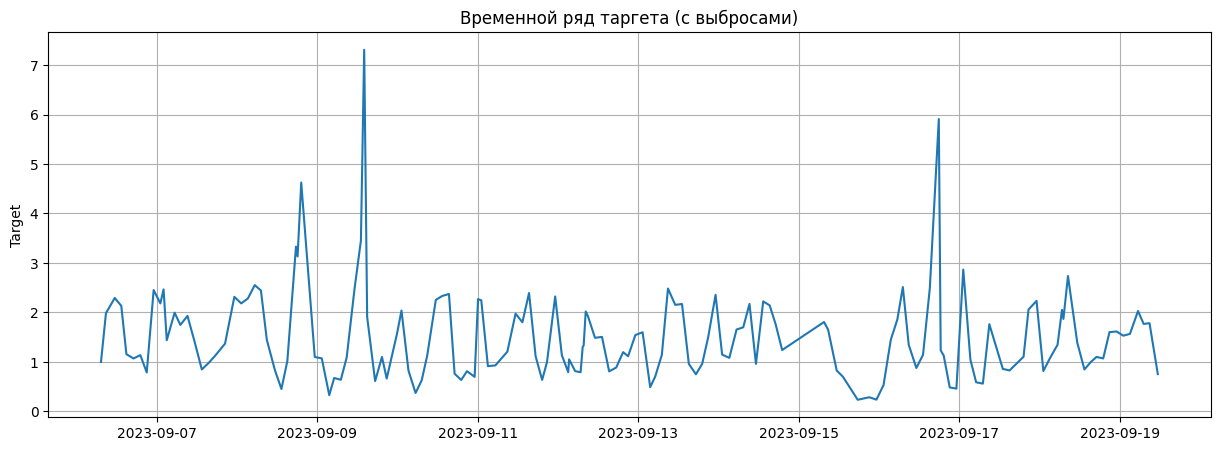

In [ ]:
plt.figure(figsize=(15, 5))
plt.plot(target_df['timestamp'], target_df['target'])
plt.ylabel('Target')
plt.title('Временной ряд таргета (с выбросами)')
plt.grid()
plt.show()

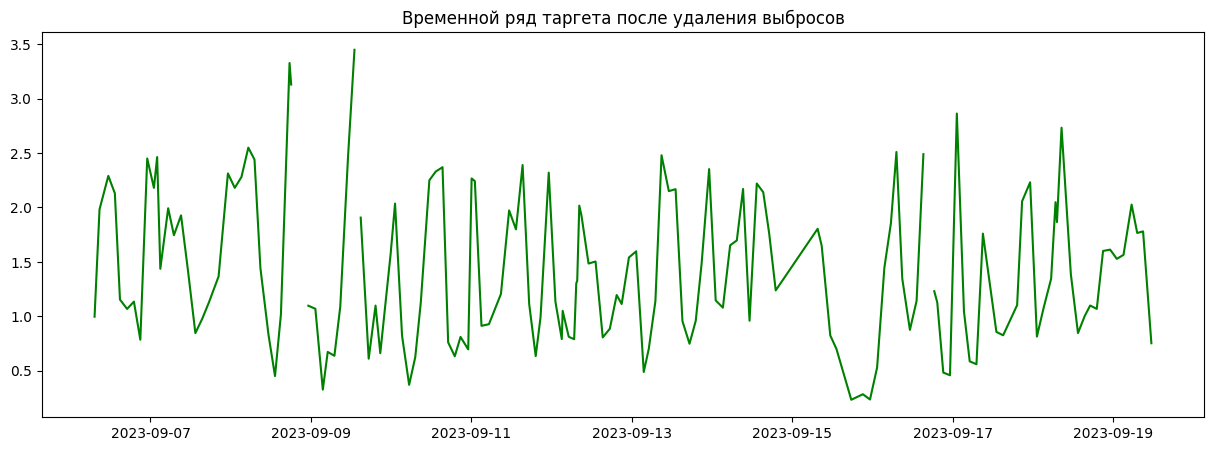

In [ ]:
# Функция для удаления выбросов
def remove_outliers(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1

    # Границы для выбросов
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Фильтрация выбросов
    filtered_series = series[(series >= lower_bound) & (series <= upper_bound)]

    return filtered_series

# Применение функции для удаления выбросов
cleaned_df = remove_outliers(target_df)

# Визуализация очищенных данных без выбросов
plt.figure(figsize=(15, 5))
plt.plot(cleaned_df['timestamp'], cleaned_df['target'], color='green')
plt.title("Временной ряд таргета после удаления выбросов")
plt.show()

Text(0.5, 1.0, 'Динамика таргета за сутки')

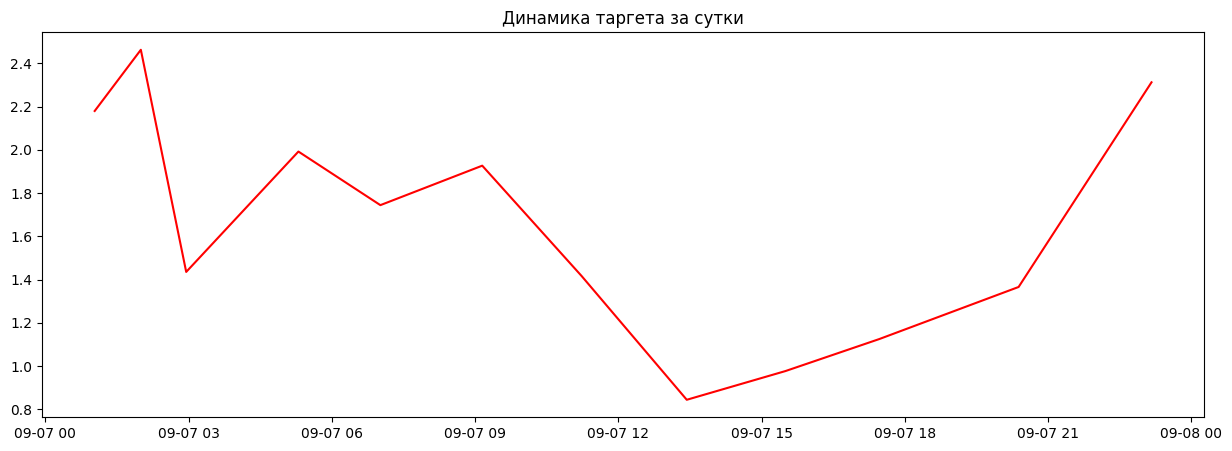

In [ ]:
# Смотрим динамику за сутки
one_day_data = cleaned_df[cleaned_df['timestamp'].dt.date == pd.to_datetime('2023-09-07').date()]

plt.figure(figsize=(15, 5))
plt.plot(one_day_data['timestamp'], one_day_data['target'], color='red')
plt.title("Динамика таргета за сутки")


In [ ]:
#анализ расширенных данных

merged_df = pd.merge(target_df, full_df, on='timestamp', how='inner')
merged_df


,timestamp,target_x,Unnamed: 0,ppm1,temp1,temp2,ppm2,gas_opening1,press1,rotationspeed1,...,SIM2,LSF2,electric_ampere2,electric_ampere3,temp5,target_y,target_ffill,electric_ampere_delta1,coeffs_current1,coeffs_temp1
0,2023-09-06 07:17:00+00:00,0.99480,3017,1195.454350,831.816895,847.329819,8.844165,80.359341,0.853588,0.000000,...,2.195150,99.441243,53.250000,59.571020,852.998840,NaN,NaN,4.497253,-0.283300,-1.029347
1,2023-09-06 08:46:00+00:00,1.98218,3107,783.813660,861.809616,932.859497,15.954841,75.158239,69.342266,54.992676,...,2.175992,98.794070,53.750000,57.388342,852.419662,NaN,NaN,8.135651,-0.285753,1.563083
2,2023-09-06 11:24:00+00:00,2.29000,3266,974.142900,827.810303,889.851013,13.066117,75.452110,67.686630,54.992676,...,2.199200,98.607253,53.000000,58.000000,843.419067,NaN,NaN,7.580719,-0.100042,-0.597650
3,2023-09-06 13:21:00+00:00,2.13000,3384,1948.471560,862.816055,907.555695,8.719776,73.096607,64.652056,54.992676,...,2.176811,97.056086,52.750000,58.106323,857.005508,NaN,NaN,10.781342,0.343562,-0.412944
4,2023-09-06 14:53:00+00:00,1.15249,3477,2005.705440,835.234940,946.406601,8.579731,73.942961,64.414242,54.992676,...,2.174094,97.952924,52.000000,58.466889,849.970154,NaN,NaN,7.525177,-0.721082,0.328343
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
153,2023-09-19 03:01:00+00:00,1.56381,21631,1486.022339,789.975311,915.880859,8.154297,78.840240,74.009872,54.992676,...,2.326323,98.579387,55.000000,60.288050,834.095551,NaN,1.56381,23.013550,-0.734049,0.416668
154,2023-09-19 05:26:00+00:00,2.02632,21777,1417.788940,786.614349,839.482040,10.465495,77.378109,72.027811,0.000000,...,2.282914,101.062051,57.500000,59.498257,832.206238,NaN,2.02632,23.635620,0.172004,-0.022869
155,2023-09-19 07:07:00+00:00,1.76522,21879,626.393616,796.108643,879.446976,19.202112,77.100513,72.015156,0.000000,...,2.124862,98.666131,54.500000,61.000000,845.260941,NaN,1.76522,4.581818,-0.367207,0.622986
156,2023-09-19 08:52:00+00:00,1.77973,21985,2005.786255,801.390747,954.091919,6.597222,75.185666,69.244311,54.992676,...,2.115010,98.840742,54.333333,61.756232,841.583455,NaN,1.77973,NaN,-0.962350,0.664535


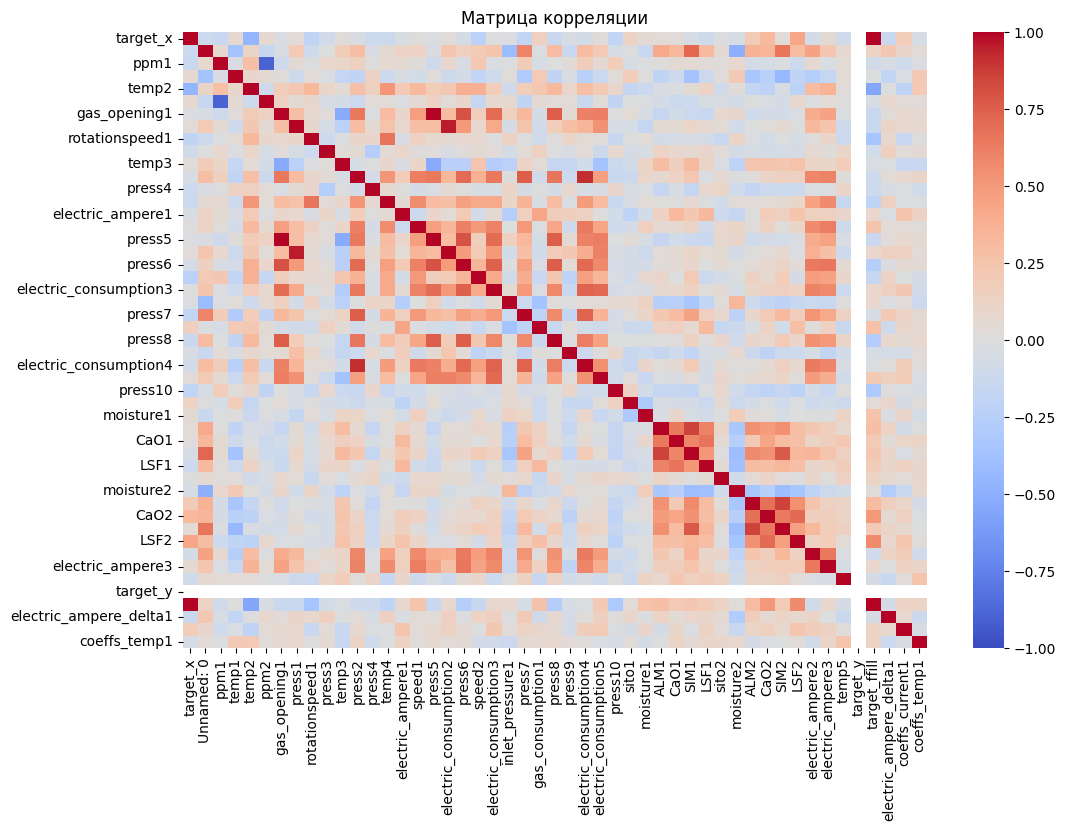

In [ ]:
#матрица корреляции

correlation = merged_df.drop(columns=['timestamp']).corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation, annot=False, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Матрица корреляции")
plt.show()


In [ ]:
target_corr = correlation['target_x'].sort_values(ascending=False)
target_corr[target_corr > 0.3]

,target_x
target_x,1.000000
target_ffill,1.000000
LSF2,0.436420
CaO2,0.312542


По предварительному анализу есть корреляция с LSF2 и CaO2, будем иметь в виду (по условиям не до конца известно, получаем мы эти данные в реальном времени и не будут ли они "подсказывать" модели)

In [ ]:
target_df['timestamp'] = pd.to_datetime(target_df['timestamp'])  # Преобразуем колонку в тип datetime
target_df.set_index('timestamp', inplace=True)  # Устанавливаем 'timestamp' как индекс

target_df

,target
timestamp,
2023-09-06 07:17:00+00:00,0.99480
2023-09-06 08:46:00+00:00,1.98218
2023-09-06 11:24:00+00:00,2.29000
2023-09-06 13:21:00+00:00,2.13000
2023-09-06 14:53:00+00:00,1.15249
...,...
2023-09-19 03:01:00+00:00,1.56381
2023-09-19 05:26:00+00:00,2.02632
2023-09-19 07:07:00+00:00,1.76522


In [ ]:
# Ресемплируем таргет с частотой 1 минута
target_resampled = target_df.resample('1min').interpolate(method='linear')
merged_resampled = pd.merge(target_resampled, full_df, on='timestamp', how='inner')
merged_resampled = merged_resampled[['timestamp','target_x']].set_index('timestamp')
merged_resampled

,target_x
timestamp,
2023-09-06 07:17:00+00:00,0.994800
2023-09-06 07:18:00+00:00,1.005894
2023-09-06 07:19:00+00:00,1.016988
2023-09-06 07:20:00+00:00,1.028082
2023-09-06 07:21:00+00:00,1.039177
...,...
2023-09-19 11:17:00+00:00,0.778335
2023-09-19 11:18:00+00:00,0.771429
2023-09-19 11:19:00+00:00,0.764522


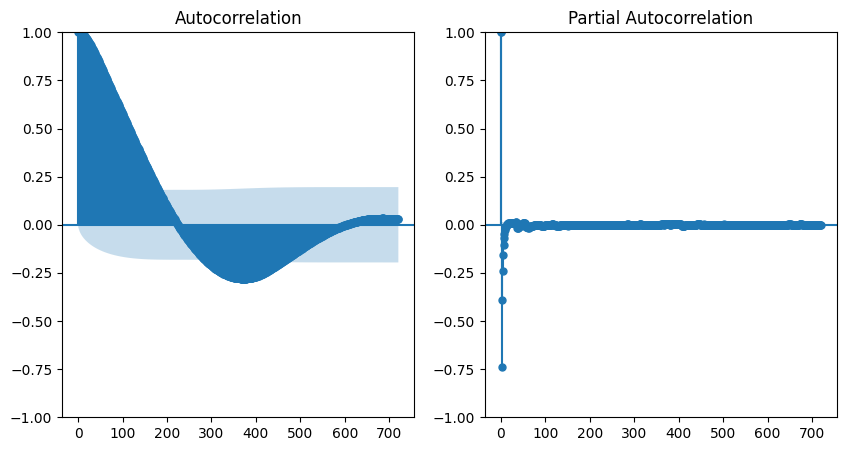

In [ ]:
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
plot_acf(merged_resampled['target_x'], lags=720, ax=axes[0])
plot_pacf(merged_resampled['target_x'], lags=720, ax=axes[1], method = 'ywm')
plt.show()

Существует значительная корреляция между химическими показателями в клинкере за предыдущие минуты и показателями в будущем (но на короткий промежуток времени).
Нет выраженного сезонного компонента, нет тренда. Для создания ВД можно попробовать ARIMA, линейную регрессию или бустинг

# Виртуальный датчик

Цель: Предсказывать текущее значение таргета (target_x) в режиме реального времени на основе текущих и прошлых данных.
Целевая переменная: Текущие значения таргета.

In [ ]:
merged_resampled

,target_x
timestamp,
2023-09-06 07:17:00+00:00,0.994800
2023-09-06 07:18:00+00:00,1.005894
2023-09-06 07:19:00+00:00,1.016988
2023-09-06 07:20:00+00:00,1.028082
2023-09-06 07:21:00+00:00,1.039177
...,...
2023-09-19 11:17:00+00:00,0.778335
2023-09-19 11:18:00+00:00,0.771429
2023-09-19 11:19:00+00:00,0.764522


In [ ]:
# from sklearn.preprocessing import MinMaxScaler
# scaler = MinMaxScaler()

# # Масштабируем только числовые колонки
# numerical_columns = ['target_x', 'gas_opening1', 'LSF2', 'CaO2']

# # Нормализуем данные для всех частей (train, val, test)
# data_train[numerical_columns] = scaler.fit_transform(data_train[numerical_columns])
# data_val[numerical_columns] = scaler.transform(data_val[numerical_columns])
# data_test[numerical_columns] = scaler.transform(data_test[numerical_columns])


In [ ]:
# Добавления лагов для предсказания на 15 минут
for i in range(1, 16):  # 15 лагов
    merged_resampled[f'target_lag_{i}'] = merged_resampled['target_x'].shift(i)

merged_resampled = merged_resampled.dropna()
merged_resampled

,target_x,target_lag_1,target_lag_2,target_lag_3,target_lag_4,target_lag_5,target_lag_6,target_lag_7,target_lag_8,target_lag_9,target_lag_10,target_lag_11,target_lag_12,target_lag_13,target_lag_14,target_lag_15
timestamp,,,,,,,,,,,,,,,,
2023-09-06 07:32:00+00:00,1.161212,1.150118,1.139024,1.127930,1.116836,1.105742,1.094647,1.083553,1.072459,1.061365,1.050271,1.039177,1.028082,1.016988,1.005894,0.994800
2023-09-06 07:33:00+00:00,1.172307,1.161212,1.150118,1.139024,1.127930,1.116836,1.105742,1.094647,1.083553,1.072459,1.061365,1.050271,1.039177,1.028082,1.016988,1.005894
2023-09-06 07:34:00+00:00,1.183401,1.172307,1.161212,1.150118,1.139024,1.127930,1.116836,1.105742,1.094647,1.083553,1.072459,1.061365,1.050271,1.039177,1.028082,1.016988
2023-09-06 07:35:00+00:00,1.194495,1.183401,1.172307,1.161212,1.150118,1.139024,1.127930,1.116836,1.105742,1.094647,1.083553,1.072459,1.061365,1.050271,1.039177,1.028082
2023-09-06 07:36:00+00:00,1.205589,1.194495,1.183401,1.172307,1.161212,1.150118,1.139024,1.127930,1.116836,1.105742,1.094647,1.083553,1.072459,1.061365,1.050271,1.039177
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-09-19 11:17:00+00:00,0.778335,0.785241,0.792147,0.799053,0.805959,0.812866,0.819772,0.826678,0.833584,0.840490,0.847396,0.854303,0.861209,0.868115,0.875021,0.881927
2023-09-19 11:18:00+00:00,0.771429,0.778335,0.785241,0.792147,0.799053,0.805959,0.812866,0.819772,0.826678,0.833584,0.840490,0.847396,0.854303,0.861209,0.868115,0.875021
2023-09-19 11:19:00+00:00,0.764522,0.771429,0.778335,0.785241,0.792147,0.799053,0.805959,0.812866,0.819772,0.826678,0.833584,0.840490,0.847396,0.854303,0.861209,0.868115


In [ ]:
total_length = len(merged_resampled)

train_end_idx = int(total_length * 0.7)  # 70% данных для тренировки
val_end_idx = int(total_length * 0.9)   # 90% данных для валидации

end_train = merged_resampled.index[train_end_idx]
end_validation = merged_resampled.index[val_end_idx]

data_train = merged_resampled.loc[: end_train, :]
data_val   = merged_resampled.loc[end_train:end_validation, :]
data_test  = merged_resampled.loc[end_validation:, :]

print(f"Dates train      : {data_train.index.min()} --- {data_train.index.max()}  (n={len(data_train)})")
print(f"Dates validacion : {data_val.index.min()} --- {data_val.index.max()}  (n={len(data_val)})")
print(f"Dates test       : {data_test.index.min()} --- {data_test.index.max()}  (n={len(data_test)})")

Dates train      : 2023-09-06 07:32:00+00:00 --- 2023-09-15 12:37:00+00:00  (n=13266)
Dates validacion : 2023-09-15 12:37:00+00:00 --- 2023-09-18 03:47:00+00:00  (n=3791)
Dates test       : 2023-09-18 03:47:00+00:00 --- 2023-09-19 11:21:00+00:00  (n=1895)


В целом мы не будем сильно менять параметры/гиперпараметры, можно оставить только 80/20 тренировки и теста

In [ ]:
# линейная регрессия
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Разделяем данные на X (признаки) и y (целевая переменная)
X_train = data_train.drop(columns=['target_x'])
y_train = data_train['target_x']

X_val = data_val.drop(columns=['target_x'])
y_val = data_val['target_x']

X_test = data_test.drop(columns=['target_x'])
y_test = data_test['target_x']

# Создаем и обучаем модель
model = LinearRegression()
model.fit(X_train, y_train)


# Оценка модели на тренировочном наборе
y_train_pred = model.predict(X_train)
mse_train = mean_squared_error(y_train, y_train_pred)
rmse_train = np.sqrt(mse_train)

# Предсказания на валидационном и тестовом наборе
y_val_pred = model.predict(X_val)
y_val_pred = pd.Series(y_val_pred, index=y_val.index)

y_test_pred = model.predict(X_test)
y_test_pred = pd.Series(y_test_pred, index=y_test.index)



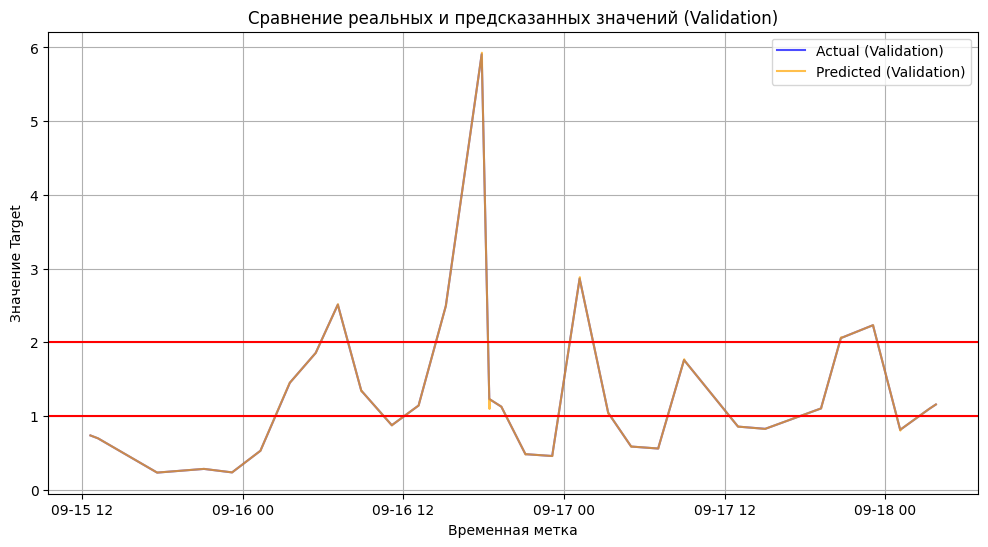

In [ ]:
# Построение графика реальных и предсказанных значений на валидационном и тестовом наборе
plt.figure(figsize=(12, 6))

# Валидационный набор
plt.plot(y_val.index, y_val, label="Actual (Validation)", color="blue", alpha=0.7)
plt.plot(y_val.index, y_val_pred, label="Predicted (Validation)", color="orange", alpha=0.7)

# Тестовый набор
# plt.plot(y_test.index, y_test, label="Actual (Test)", color="green", alpha=0.7)
# plt.plot(y_test.index, y_test_pred, label="Predicted (Test)", color="red", alpha=0.7)

# Добавление линий на уровне 1 и 2
plt.axhline(y=1, color='red')
plt.axhline(y=2, color='red')

plt.title("Сравнение реальных и предсказанных значений (Validation)")
plt.xlabel("Временная метка")
plt.ylabel("Значение Target")
plt.legend()
plt.grid()
plt.show()


In [ ]:
rmse_val = np.sqrt(mean_squared_error(y_val, y_val_pred))
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))

print(f"RMSE на валидационных данных: {rmse_val}")
print(f"RMSE на тестовых данных: {rmse_test}")

RMSE на валидационных данных: 0.0034840139302160698
RMSE на тестовых данных: 0.0007784897353982634


In [ ]:
#бустинг
!pip install --upgrade lightgbm

from lightgbm import LGBMRegressor, plot_metric

# Разделяем данные на X (признаки) и y (целевая переменная)
X_train_lgb = data_train.drop(columns=['target_x'])
y_train_lgb = data_train['target_x']

X_val_lgb = data_val.drop(columns=['target_x'])
y_val_lgb = data_val['target_x']

X_test_lgb = data_test.drop(columns=['target_x'])
y_test_lgb = data_test['target_x']

# Создаем и обучаем модель
gb_model = LGBMRegressor(random_state=20, verbose=-1, num_iterations=350,
                         learning_rate= 0.01, max_depth=15)
gb_model.fit(X_train, y_train, eval_set=[(X_test_lgb, y_test_lgb), (X_train_lgb, y_train_lgb)])

# Делаем предсказания
y_val_pred_lgb = gb_model.predict(X_val_lgb)
y_val_pred_lgb = pd.Series(y_val_pred_lgb, index=y_val_lgb.index)

y_test_pred_lgb = gb_model.predict(X_test_lgb)
y_test_pred_lgb = pd.Series(y_test_pred_lgb, index=y_test_lgb.index)

# Оценим качество на валидации и тесте
rmse_val_lgb = np.sqrt(mean_squared_error(y_val_lgb, y_val_pred_lgb))
rmse_test_lgb = np.sqrt(mean_squared_error(y_test_lgb, y_test_pred_lgb))
print(f"RMSE на валидационных данных (LGB): {rmse_val_lgb}")
print(f"RMSE на тестовых данных (LGB): {rmse_test_lgb}")


/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


RMSE на валидационных данных (LGB): 0.09666982058164837
RMSE на тестовых данных (LGB): 0.015011160000082516


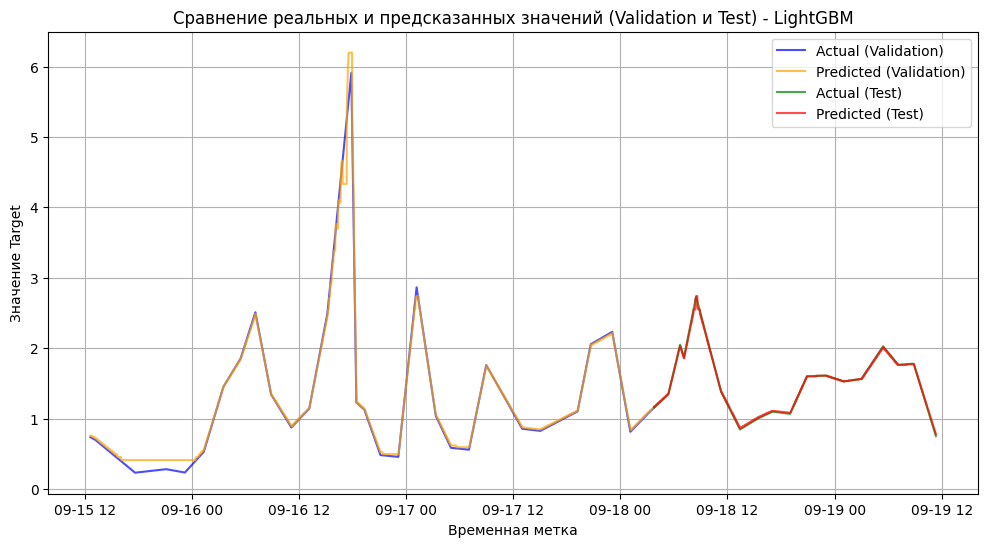

In [ ]:
# Визуализируем реальные и предсказанные значения
plt.figure(figsize=(12, 6))
plt.plot(y_val_lgb.index, y_val_lgb, label="Actual (Validation)", color="blue", alpha=0.7)
plt.plot(y_val_lgb.index, y_val_pred_lgb, label="Predicted (Validation)", color="orange", alpha=0.7)

plt.plot(y_test_lgb.index, y_test_lgb, label="Actual (Test)", color="green", alpha=0.7)
plt.plot(y_test_lgb.index, y_test_pred_lgb, label="Predicted (Test)", color="red", alpha=0.7)

plt.title("Сравнение реальных и предсказанных значений (Validation и Test) - LightGBM")
plt.xlabel("Временная метка")
plt.ylabel("Значение Target")
plt.legend()
plt.grid()
plt.show()

Линейная регрессия дает достаточно хорошее предсказание без дополнительных данных (коррелирующих признаков), отследить  показатель <1 или >2 можно. Будем использовать ее для дальнейших предсказаний

In [ ]:
model_virtual_sensor = LinearRegression()
model_virtual_sensor.fit(X_train, y_train)

LinearRegression()

In [ ]:
# Переменная для виртуального датчика
sensor_target = y_val.copy()
sensor_target[:] = y_val_pred
sensor_target

,target_x
timestamp,
2023-09-15 12:37:00+00:00,0.735236
2023-09-15 12:38:00+00:00,0.734119
2023-09-15 12:39:00+00:00,0.733002
2023-09-15 12:40:00+00:00,0.731885
2023-09-15 12:41:00+00:00,0.730769
...,...
2023-09-18 03:43:00+00:00,1.147338
2023-09-18 03:44:00+00:00,1.149328
2023-09-18 03:45:00+00:00,1.151319


# Предсказание на 15 минут

Цель: Предсказывать значение таргета через 15 минут от текущего момента на основе текущих и прошлых данных.
Целевая переменная: Значения таргета, сдвинутые на 15 минут вперёд.

In [ ]:
# Создание целевой переменной для прогноза на 15 минут вперёд
merged_resampled['target_15min_future'] = merged_resampled['target_x'].shift(-15)
merged_resampled = merged_resampled.dropna()

total_length = len(merged_resampled)
train_future_end_idx = int(total_length * 0.8)
test_future_end_idx = total_length

end_train_future = merged_resampled.index[train_future_end_idx]

data_train = merged_resampled.loc[:end_train_future, :]
data_test = merged_resampled.loc[end_train_future:, :]

print(f"Dates train  : {data_train.index.min()} --- {data_train.index.max()}  (n={len(data_train)})")
print(f"Dates test   : {data_test.index.min()} --- {data_test.index.max()}  (n={len(data_test)})")

Dates train  : 2023-09-06 07:32:00+00:00 --- 2023-09-16 20:00:00+00:00  (n=15149)
Dates test   : 2023-09-16 20:00:00+00:00 --- 2023-09-19 11:06:00+00:00  (n=3787)


<ipython-input-31-501e4eb2675f>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_resampled['target_15min_future'] = merged_resampled['target_x'].shift(-15)


In [ ]:
from sklearn.preprocessing import MinMaxScaler

# скейлер
# scaler = MinMaxScaler()
# numerical_columns = ['target_x', 'target_15min_future']
# scaler.fit(data_train[numerical_columns])
# data_train_future = data_train.copy()
# data_test_future = data_test.copy()
# data_train_future[numerical_columns] = scaler.transform(data_train[numerical_columns])
# data_test_future[numerical_columns] = scaler.transform(data_test[numerical_columns])

# Разделяем данные на X (признаки) и y (целевая переменная)
X_train_forecast = data_train.drop(columns=['target_x', 'target_15min_future'])
y_train_forecast = data_train['target_15min_future']

X_test_forecast = data_test.drop(columns=['target_x', 'target_15min_future'])
y_test_forecast = data_test['target_15min_future']

# Создаем и обучаем модель линейной регрессии
model_forecast = LinearRegression()
model_forecast.fit(X_train_forecast, y_train_forecast)

y_train_pred_forecast = model_forecast.predict(X_train_forecast)
rmse_train_forecast = np.sqrt(mean_squared_error(y_train_forecast, y_train_pred_forecast))
print(f"RMSE на тренировочных данных (Прогноз 15 мин): {rmse_train_forecast}")

RMSE на тренировочных данных (Прогноз 15 мин): 0.08774258490909863


RMSE на тестовых данных (Прогноз 15 мин): 0.03764981082383799


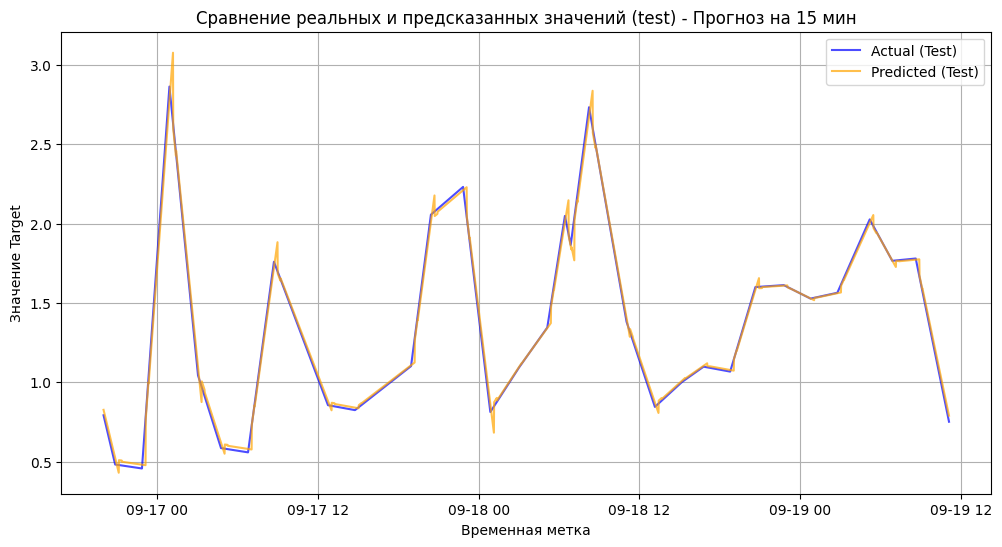

In [ ]:
y_test_pred_forecast = model_forecast.predict(X_test_forecast)

rmse_test_forecast = np.sqrt(mean_squared_error(y_test_forecast, y_test_pred_forecast))

print(f"RMSE на тестовых данных (Прогноз 15 мин): {rmse_test_forecast}")

plt.figure(figsize=(12, 6))
plt.plot(y_test_forecast.index, y_test_forecast, label="Actual (Test)", color="blue", alpha=0.7)
plt.plot(y_test_forecast.index, y_test_pred_forecast, label="Predicted (Test)", color="orange", alpha=0.7)
plt.title("Сравнение реальных и предсказанных значений (test) - Прогноз на 15 мин")
plt.xlabel("Временная метка")
plt.ylabel("Значение Target")
plt.legend()
plt.grid()
plt.show()

Результат нормальный

# Изменение трагета при изменении gas_consumption1

мы берем конкретный момент времени, создаем два сценария развития следующих 15 минут (с обычным gas_consumption1 и с увеличенным на 150) и смотрим, как это повлияет на таргет

In [ ]:
#full_df['timestamp'] = pd.to_datetime(full_df['timestamp'])
gas_df = full_df[['timestamp','gas_consumption1']]
gas_df.set_index('timestamp', inplace=True)
gas_df = gas_df.resample('1min').interpolate(method='linear')
gas_df = pd.merge(gas_df, merged_resampled, on='timestamp', how='inner')
gas_df = gas_df[['gas_consumption1', 'target_x', 'target_15min_future']]
gas_df


,gas_consumption1,target_x,target_15min_future
timestamp,,,
2023-09-06 07:32:00+00:00,8984.849365,1.161212,1.327625
2023-09-06 07:33:00+00:00,8985.637207,1.172307,1.338719
2023-09-06 07:34:00+00:00,8987.212158,1.183401,1.349813
2023-09-06 07:35:00+00:00,8987.212158,1.194495,1.360907
2023-09-06 07:36:00+00:00,8995.349609,1.205589,1.372001
...,...,...,...
2023-09-19 11:02:00+00:00,8558.812012,0.881927,0.778335
2023-09-19 11:03:00+00:00,8560.386963,0.875021,0.771429
2023-09-19 11:04:00+00:00,8563.537109,0.868115,0.764522


In [ ]:
test_start = '2023-09-15 12:00:00'
print(test_start in gas_df.index)

True


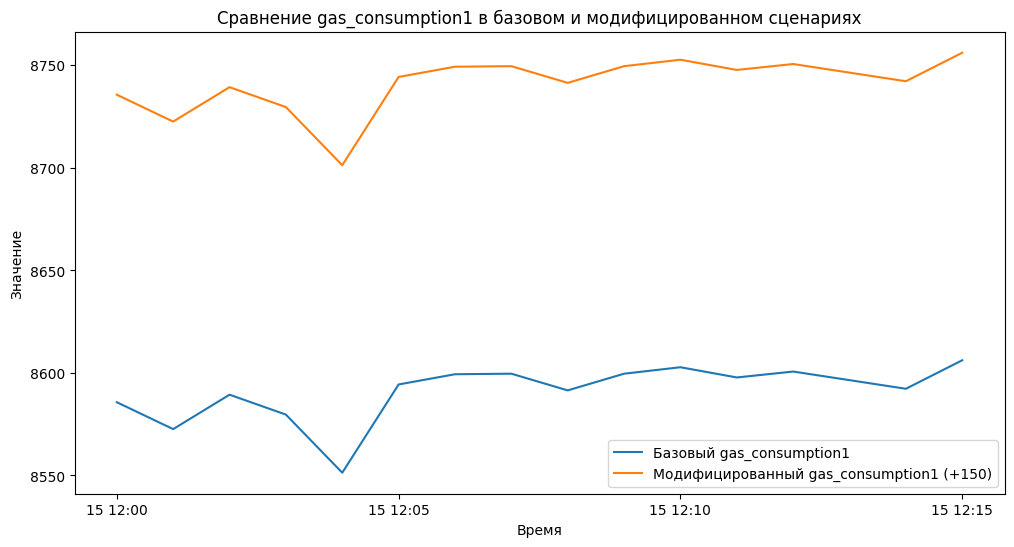


Базовый сценарий:
                           gas_consumption1  target_x
timestamp                                            
2023-09-15 12:00:00+00:00       8585.586914  0.776403
2023-09-15 12:01:00+00:00       8572.462158  0.775286
2023-09-15 12:02:00+00:00       8589.261963  0.774169
2023-09-15 12:03:00+00:00       8579.549561  0.773052
2023-09-15 12:04:00+00:00       8551.199219  0.771935

Модифицированный сценарий (gas_consumption1 +150):
                           gas_consumption1  target_x
timestamp                                            
2023-09-15 12:00:00+00:00       8735.586914  0.776403
2023-09-15 12:01:00+00:00       8722.462158  0.775286
2023-09-15 12:02:00+00:00       8739.261963  0.774169
2023-09-15 12:03:00+00:00       8729.549561  0.773052
2023-09-15 12:04:00+00:00       8701.199219  0.771935


In [ ]:
# Берем произвольный момент времени для предсказания на 15 минут
test_start = '2023-09-15 12:00:00'
test_end = '2023-09-15 12:15:00'

# Создаем сценарии для тестов
base_scenario = gas_df.loc[test_start:test_end].copy()
modified_scenario = gas_df.loc[test_start:test_end].copy()
modified_scenario['gas_consumption1'] += 150

# Визуализируем для проверки
plt.figure(figsize=(12,6))
plt.plot(base_scenario.index, base_scenario['gas_consumption1'],
        label='Базовый gas_consumption1')
plt.plot(modified_scenario.index, modified_scenario['gas_consumption1'],
        label='Модифицированный gas_consumption1 (+150)')
plt.title('Сравнение gas_consumption1 в базовом и модифицированном сценариях')
plt.xlabel('Время')
plt.ylabel('Значение')
plt.legend()
plt.show()

print("\nБазовый сценарий:")
print(base_scenario[['gas_consumption1', 'target_x']].head())
print("\nМодифицированный сценарий (gas_consumption1 +150):")
print(modified_scenario[['gas_consumption1', 'target_x']].head())

In [ ]:
X = gas_df.drop(columns=['target_x', 'target_15min_future'])
y = gas_df['target_15min_future']

split_lenght = int(0.8 * len(X))
X_train, X_test = X[:split_lenght], X[split_lenght:]
y_train, y_test = y[:split_lenght], y[split_lenght:]

# Обучение модели
model_forecast = LinearRegression()
model_forecast.fit(X_train, y_train)

y_pred = model_forecast.predict(X_test)
print("RMSE на тесте:", np.sqrt(mean_squared_error(y_test, y_pred)))

#сравнение сценариев
base_predict = model_forecast.predict(base_scenario.drop(columns=['target_x', 'target_15min_future']))
modified_predict = model_forecast.predict(modified_scenario.drop(columns=['target_x', 'target_15min_future']))



RMSE на тесте: 0.527499801247669


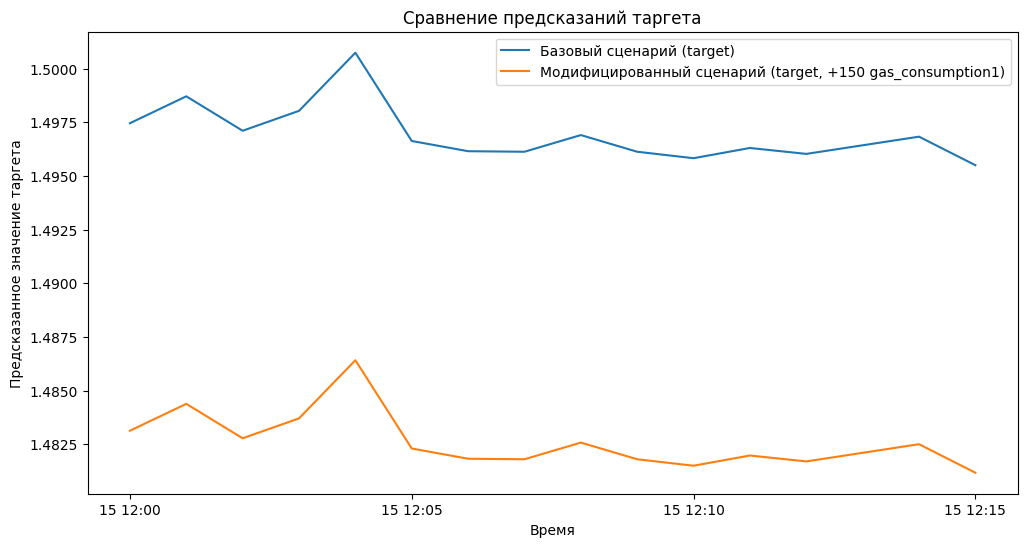

In [ ]:
# Визуализируем сравнение предсказаний
plt.figure(figsize=(12, 6))
plt.plot(base_scenario.index, base_predict, label='Базовый сценарий (target)')
plt.plot(modified_scenario.index, modified_predict, label='Модифицированный сценарий (target, +150 gas_consumption1)')
plt.title('Сравнение предсказаний таргета')
plt.xlabel('Время')
plt.ylabel('Предсказанное значение таргета')
plt.legend()
plt.show()


Увеличение gas_consumption1 на 150 привело к снижению предсказанного значения таргета